# Prueba de concepto de embedings de frases para calcular similaridad. Las recomendaciones se hacen en función de las overviews de las peliculas del dataset comparada con la overview de la pelicula que se da de input.

/Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config_sentence_transformers.json: 100%|██████████| 122/122 [00:00<00:00, 182kB/s]
README.md: 100%|██████████| 3.95k/3.95k [00:00<00:00, 6.53MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 59.7kB/s]
config.json: 100%|██████████| 625/625 [00:00<00:00, 1.07MB/s]
pytorch_model.bin: 100%|██████████| 438M/438M [00:04<00:00, 102MB/s]  
tokenizer_config.json: 100%|██████████| 399/399 [00:00<00:00, 172kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.10MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 4.54MB/s]
added_tokens.json: 100%|██████████| 2.00/2.00 [00:00<00:00, 5.89kB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 433kB/s]


(7, 768)
[[ 1.00000012  0.18692744  0.28297654  0.29628217  0.27451023  0.10176258
   0.21696249]
 [ 0.18692744  1.          0.72058785  0.51428944  0.11749668  0.19306904
   0.66182345]
 [ 0.28297654  0.72058785  1.          0.48864424  0.23568946  0.17157142
   0.55993092]
 [ 0.29628217  0.51428944  0.48864424  0.99999976  0.26985502  0.37889433
   0.52388805]
 [ 0.27451023  0.11749668  0.23568946  0.26985502  1.          0.2342214
  -0.01599779]
 [ 0.10176258  0.19306904  0.17157142  0.37889433  0.2342214   1.
   0.22319655]
 [ 0.21696249  0.66182345  0.55993092  0.52388805 -0.01599779  0.22319655
   1.        ]]


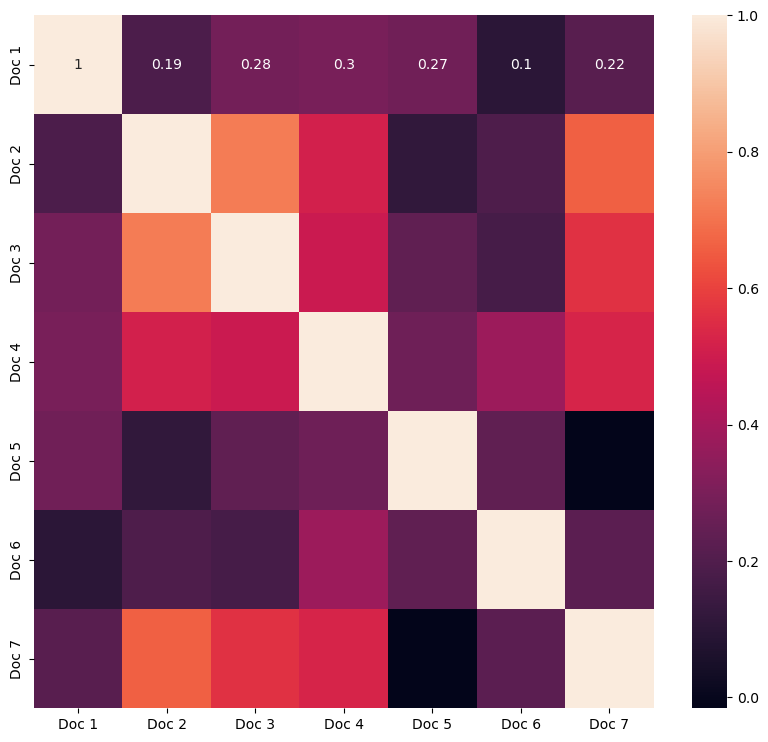

In [1]:

a = "purple is the best city in the forest"
b = "there is an art to getting your way and throwing bananas on to the street is not it"
c= "it is not often you find soggy bananas on the street"
d = "green should have smelled more tranquil but somehow it just tasted rotten"
e= "joyce enjoyed eating pancakes with ketchup"
f = "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled"
g = "to get your way you must not bombard the road with yellow fruit"

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embeddings = model.encode([a, b, c, d, e, f, g])

print(sentence_embeddings.shape)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculte similarities ( Will be stored in an array )
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
for i in range(sentence_embeddings.shape[0]):
    scores[i, :] = cosine_similarity(
        [sentence_embeddings[i]],
        sentence_embeddings ) [0]

print(scores)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,9))
labels = ['Doc 1','Doc 2','Doc 3','Doc 4', 'Doc 5', 'Doc 6', 'Doc 7']
sim_map = sns.heatmap(scores, xticklabels = labels, yticklabels = labels, annot = True)

# Cargo el dataset de peliculas

In [2]:
import pandas as pd
df = pd.read_csv('movies_metadata.csv')

/var/folders/yc/q9_6ht1x43s552t2rfm6pw1c0000gn/T/ipykernel_39311/1306873364.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


In [3]:
# Columna de overviews
film_overviews = df['overview'].tolist()


In [4]:
def calculate_similarity(input_sentence, document_embeddings):
    input_embedding = model.encode([input_sentence])
    scores = cosine_similarity(input_embedding, document_embeddings)[0]
    return scores

In [5]:
from sentence_transformers import SentenceTransformer# esta librería la usaré para calcular los embedings de los overviews

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [5]:
!pip install gradio==4.14.0

In [17]:
import gradio as gr
import random
import requests
from dotenv import load_dotenv
import matplotlib
import os
from PIL import Image, ImageTk
import tkinter as tk
import io

# Cargar variables de entorno desde .env
load_dotenv()

url_omdb = "http://www.omdbapi.com/?apikey=" + os.getenv("OMDB_API_KEY") + "&t="
# Assume you have already loaded your dataframe and preprocessed it
# df = ...

# Select the first 100 films for testing
df_subset = df.head(1000)
df_subset = df_subset.dropna(subset=['overview']).reset_index(drop=True)
# Gradio function to calculate similarity and return top 5 similar films
def find_similar_films(film_name):
    # Get the overview of the specified film
    overview = df_subset[df_subset['original_title'] == film_name]['overview'].values
    if len(overview) == 0 or pd.isna(overview[0]) or not isinstance(overview[0], str):
        return "Film overview not available or invalid."

    overview = overview[0]
    # Calculate similarity scores
    film_overview_embeddings = model.encode(df_subset['overview'])
    similarity_scores = calculate_similarity(overview, film_overview_embeddings)

    # Create a dataframe with film titles and their similarity scores
    result_df = pd.DataFrame({'Film': df_subset['original_title'], 'Similarity Score': similarity_scores})
    result_df = result_df[result_df['Film'] != film_name]
    # Sort the dataframe by similarity scores in descending order
    result_df = result_df.sort_values(by='Similarity Score', ascending=False)
    top_5_films = result_df.head(5)

    # Get the poster URL of the most similar movie
    most_similar_title = top_5_films.iloc[0]['Film']
    try:
        most_similar_poster = get_poster(most_similar_title)
    except Exception as e:
        return {"Error": str(e)}

    # Get the image content from the URL
    try:
        image_content = requests.get(most_similar_poster).content
    except Exception as e:
        return {"Error": str(e)}

    # Create a PIL Image object from the bytes
    try:
        image = Image.open(io.BytesIO(image_content))
    except Exception as e:
        return {"Error": str(e)}

    # Return the PIL Image object
    return image



def get_poster(movie):
    """ 
    Devuelve la ruta al poster en jpg
    
    Args:
        movie (str): El título de la película
    """
    movie = movie.lower().replace(" ", "+")
    result = requests.get(url_omdb + movie)
    result_json = result.json()
    return result_json['Poster']

input_text = gr.Textbox(label="Enter Movie Title")
output_posters = gr.Image()

# Create Gradio Interface for finding similar films
find_similar_films_interface = gr.Interface(fn=find_similar_films, inputs=input_text, outputs=output_posters, title='Aplicacion de paliculas', description='this app helps you reccomending movies based \
                                            on the movies you previously liked')

# Launch the interface
find_similar_films_interface.launch()








Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


In [20]:
# HTML code for custom styling
html_code = """
<style>
    body {
        font-family: Arial, sans-serif;
    }

    .gr-interface {
        max-width: 800px;
        margin: auto;
    }

    .gr-title {
        font-size: 24px;
        font-weight: bold;
        margin-bottom: 10px;
    }

    .gr-description {
        font-size: 16px;
        margin-bottom: 20px;
    }

    .gr-textbox {
        width: 100%;
        margin-bottom: 20px;
    }

    .gr-output {
        display: flex;
        justify-content: space-between;
        flex-wrap: wrap;
    }

    .gr-image {
        width: 150px;
        margin-bottom: 10px;
    }
</style>
"""

# Create Gradio Interface for finding similar films with custom HTML styling
find_similar_films_interface = gr.Interface(
    fn=find_similar_films, 
    inputs=input_text, 
    outputs=output_posters, 
    live=True,
    title='Movie Recommendation App <style>.gr-title { color: #3498db; }</style>',
    description='This app helps you discover movies similar to the ones you like.'
)

# Launch the interface
find_similar_films_interface.launch(share=True, debug=True)


Running on local URL:  http://127.0.0.1:7871


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Could not create share link. Missing file: /Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/gradio/frpc_darwin_arm64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_darwin_arm64
2. Rename the downloaded file to: frpc_darwin_arm64_v0.2
3. Move the file to this location: /Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/gradio


Traceback (most recent call last):
  File "/Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/gradio/queueing.py", line 495, in call_prediction
    output = await route_utils.call_process_api(
  File "/Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/gradio/route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
  File "/Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/gradio/blocks.py", line 1570, in process_api
    data = self.postprocess_data(fn_index, result["prediction"], state)
  File "/Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/gradio/blocks.py", line 1456, in postprocess_data
    outputs_cached = processing_utils.move_files_to_cache(
  File "/Users/gustavo.aguado/anaconda3/envs/base_ml/lib/python3.9/site-packages/gradio/processing_utils.py", line 265, in move_files_to_cache
    return client_utils.traverse(data, _move_to_cache, client_utils.is

In [17]:
find_similar_films('Toy Story')

                     Film  Similarity Score
0               Toy Story          1.000000
1                 Jumanji          0.782915
94     A Midwinter's Tale          0.757052
6                 Sabrina          0.747536
71  Kicking and Screaming          0.738529


"Toy Story\nJumanji\nA Midwinter's Tale\nSabrina\nKicking and Screaming"